# <center> POVM as a quantum version of the classifier </center>

In [1]:
import pennylane as qml
from pennylane import numpy as np

from sympy import * 
from sympy.physics.quantum.circuitplot import CircuitPlot,labeller,Mz,CreateOneQubitGate
from sympy.physics.quantum.gate import *
from sympy.physics.quantum.qasm import Qasm

In [21]:
dev = qml.device('default.qubit', wires=2)
#dev = qml.device('qiskit.aer', wires=2)
#dev = qml.device('qiskit.ibmq', wires=2, shots=8192, ibmqx_token="e942e97ce86ca8c3609a4053fe6762ec3db17c41895b2d85d6a3560a1156501d57db36753f99138ecb32dca58a97ae5b38005ad39855dd92ab0e86cef852c1a2")

---
## Two-element POVM Module.

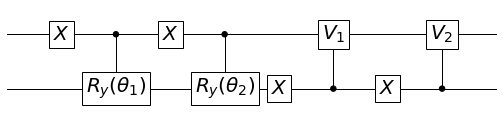

In [47]:
Ry1 = CreateOneQubitGate('Ry1', r'R_y(\theta_1)')
Ry2 = CreateOneQubitGate('Ry2', r'R_y(\theta_2)')
V1 = CreateOneQubitGate('V1', r'V_1')
V2 = CreateOneQubitGate('V2', r'V_2')

CircuitPlot(CGate(0,V2(1))*X(0)*CGate(0,V1(1))*X(0)*CGate(1,Ry2(0))*X(1)*CGate(1,Ry1(0))*X(1),2)

In [22]:
def two_element_povm(params, wire0, wire1):
    #params 

    # Controlled-RY gate controlled by first qubit in |0> state
    qml.PauliX(wires=wire0)
    qml.CRY(params[0], wires=[wire0,wire1])
    qml.PauliX(wires=wire0)
    
    # Controlled-RY gate controlled by first qubit in |1> state
    qml.CRY(params[1], wires=[wire0,wire1])
    
    # Controlled-Rotation gate (arbitrary single-qubit unitary operator) controlled by 2nd qubit in |0> state
    qml.PauliX(wires=wire1)
    qml.CRot(params[2], params[3], params[4], wires=[wire1,wire0])
    qml.PauliX(wires=wire1)

    # # Controlled-Rotation gate (arbitrary single-qubit unitary operator) controlled by 2nd qubit in |1> state
    qml.CRot(params[5], params[6], params[7], wires=[wire1,wire0])

#### Test and Drawing `two_element_povm` module

In [23]:
@qml.qnode(dev)
def povm_circuit(params):
    two_element_povm(params, 0, 1)
    return qml.expval(qml.Identity(0) @ qml.PauliZ(1))

# initial parameters
params = np.random.random([8])
povm_circuit(params)

print("Drawing a two-element POVM circuit : ")
print(povm_circuit.draw())

Drawing a two-element POVM circuit : 
 0: ──X──╭C──────────X──╭C──────────╭┤ ⟨I ⊗ Z⟩ 
 1: ─────╰RY(0.566)─────╰RY(0.673)──╰┤ ⟨I ⊗ Z⟩ 



---

---
## Preparing two arbitrary pure states

In [24]:
def state_preparation(params):
    return qml.Hadamard(wires=0)

---
## Minimum Error Discrimination

Preparation: $\{q_i,\hat{\rho}_i\}^{N}_{i=1}$ $\longleftarrow$ $\hat{\rho} = \sum_i q_i\hat{\rho}_i$. <br>

POVMs: $\{E_k\}_{k=1}^{L}$ with $\sum_{k=1}^{L} E_k = I$.

Q. Why "$N=L$" is optimal?

In general, for a state $\hat{\rho}_i$ generated in preparation, a detection event on $\hat{E}_k$ happens with probability $ p(k|i) = tr [\hat{E}_k\hat{\rho_i}] $.

$$
p_{success} = \sum_i q_i p(i|i)
$$
$$
p_{guess} = \max_{E} \sum_i q_i p(i|i)
$$
$$
p_{error} = 1 - p_{guess}
$$

For two-element POVMs $\{\hat{E}_0, \hat{E}_1\}$ on two different state prepared as $\{(q_0,\hat{\rho}_0), (q_1,\hat{\rho}_1)\}$, 
$$
p_{error} = 1 - p_{guess} = 1-\max_{\vec{\theta}}\left(q_0\text{Tr}[\hat{E}_0\hat{\rho}_0] + q_1\text{Tr}[\hat{E}_1\hat{\rho}_1] \right)
$$

---
## Classification of two different states by using POVM

$|\Psi^0_i\rangle := |\psi_0\rangle|0\rangle$ 
$\longrightarrow$ POVM $\longrightarrow$ 
$|\Psi^0_f\rangle := \left(\hat{K}_0|\psi_0\rangle\right)|0\rangle + \left(\hat{K}_1|\psi_0\rangle\right)|1\rangle$

$$
\text{Tr}[\hat{\rho}_0\hat{E}_0] = \langle\psi_0|\hat{K}^\dagger_0\hat{K}_0|\psi_0\rangle \langle 0 | 0 \rangle = \langle\psi_0|\langle 0|\hat{K}^\dagger_0\hat{K}_0|\psi_0\rangle|0\rangle\\
=\frac{1}{2}\left(\langle\psi_0|\langle 0|\hat{K}^\dagger_0\hat{K}_0|\psi_0\rangle|0\rangle + \langle\psi_0|\langle 1|\hat{K}^\dagger_1\hat{K}_1|\psi_0\rangle|1\rangle\right)\\
+\frac{1}{2}\left(\langle\psi_0|\langle 0|\hat{K}^\dagger_0\hat{K}_0|\psi_0\rangle|0\rangle - \langle\psi_0|\langle 1|\hat{K}^\dagger_1\hat{K}_1|\psi_0\rangle|1\rangle\right) \\ 
\frac{1}{2} \left(1 + \langle\Psi_f|I\otimes Z|\Psi_f\rangle\right)
$$
Similarly, $\text{Tr}[\hat{\rho}_0\hat{E}_1] = \frac{1}{2}\left(1 - \langle\Psi_f|I\otimes Z|\Psi_f\rangle\right)$.

From the minimum error discrimination, find **the optimal POVMs** for discriminating two different states:
$$
p_{error} = 1- (-1)\min_{\vec{\theta}}\left(-q_o\text{Tr}[\hat{E}_0\hat{\rho}_0] - q_1\text{Tr}[\hat{E}_1\hat{\rho}_1]\right)\\
=\min_{\vec{\theta}}\left[\frac{1}{2} - \frac{q_0}{2}\langle\Psi^0_f|I\otimes Z|\Psi^0_f\rangle + \frac{q_1}{2}\langle\Psi^1_f|I\otimes Z|\Psi^1_f\rangle\right]
$$

### Cost function : $C(\vec{\theta}) = \frac{1}{2}\left(1 - q_0\langle\Psi^0_f|I\otimes Z|\Psi^0_f\rangle + q_1\langle\Psi^1_f|I\otimes Z|\Psi^1_f\rangle\right)$

$ \langle\Psi^0_f|I\otimes Z|\Psi^0_f\rangle $

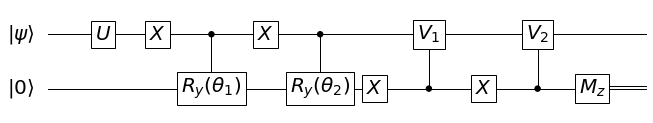

In [ ]:
U = CreateOneQubitGate('U')
Ry1 = CreateOneQubitGate('Ry1', r'R_y(\theta_1)')
Ry2 = CreateOneQubitGate('Ry2', r'R_y(\theta_2)')
V1 = CreateOneQubitGate('V1', r'V_1')
V2 = CreateOneQubitGate('V2', r'V_2')

CircuitPlot(Mz(0)*CGate(0,V2(1))*X(0)*CGate(0,V1(1))*X(0)*CGate(1,Ry2(0))*X(1)*CGate(1,Ry1(0))*X(1)*U(1), 2, labels=['0','\psi'])

---

In [ ]:
# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# set the number of steps
steps = 100

# set the initial parameter values
params = 4 * np.pi * np.random.random([11])
print("cost(init_params) =", cost(params))

for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)

    if (i+1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))

print("Optimized rotation angles: {}".format(params))

In [11]:
params=None
params=1

In [12]:
if params:
    print(params)

1


---

In [3]:
dev0 = qml.device('default.qubit', wires=2)
dev1 = qml.device('default.qubit', wires=2)

In [63]:
qnodes = qml.QNodeCollection(
    [qml.QNode(circuit_povm_expvalIZpsi0, dev0, interface="tf"), 
    qml.QNode(circuit_povm_expvalIZpsi1, dev1, interface="tf")]
)

In [64]:
params = 4 * np.pi * np.random.random([11])
qnodes(circuit, parallel=True)

/Users/Mac_dk/anaconda3/envs/quantcirc/lib/python3.8/site-packages/pennylane/collections/qnode_collection.py:218: UserWarning: Parallel execution of QNodeCollections is an experimental feature, and currently doesn't work with TensorFlow backpropagation. Please use the PyTorch or Autograd interfaces instead.
  warnings.warn(


<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.37818385, 0.91133354])>

In [69]:
def cost(x):
    prob_povm = qnodes(x)
    res = (1/2) * (1 - (1/2)*prob_povm[0] + (1/2)*prob_povm[1])
    return res.numpy()

In [71]:
cost(params)

0.5050535050993928

In [ ]:
# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# set the number of steps
steps = 100

# set the initial parameter values
params = 4 * np.pi * np.random.random([11])
print("cost(init_params) =", cost(params))

for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)

    if (i+1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))

print("Optimized rotation angles: {}".format(params))

---